In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import json
from scipy.interpolate import splprep, splev

### Init global variables

In [120]:
races_num_laps = pd.read_csv(f"./datasets/GP.csv")

In [122]:
races_laps = races_num_laps[["Name", "TotalLaps"]].sort_values(by="TotalLaps")
races_laps

,Name,TotalLaps
13,Belgian Grand Prix,44
1,Saudi Arabian Grand Prix,50
21,Las Vegas Grand Prix,50
16,Azerbaijan Grand Prix,51
11,British Grand Prix,52
3,Japanese Grand Prix,53
15,Italian Grand Prix,53
4,Chinese Grand Prix,56
18,United States Grand Prix,56
22,Qatar Grand Prix,57


In [142]:
# circuits = [
#     "Monaco", "Miami", "Saudi_Arabia", "Japan", 
#     "Bahrain", "Spain", "Canada",
#     "Emilia_Romagna", "Las_Vegas"
# ]

# race_tracks = [
#     "Monaco", "Miami", "Jeddah", "Suzuka",
#     "Sakhir", "Barcelona", "Montreal",
#     "Imola", "Las Vegas"
# ]

circuit_name = "Saudi_Arabia"
track_name = "Jeddah"

# Load data
lap_data = pd.read_csv(f"./datasets/lapdata/{circuit_name}_Grand_Prix.csv")
telem_data = pd.read_csv(f"./datasets/telemetry_data/{circuit_name}_time_series.csv")

drivers = ["NOR"]
#n_drivers = 1
#drivers = lap_data["Driver"].unique()[:n_drivers]

### Race track function definitions

In [3]:
def convert_latlon_to_xy(lat, lon, origin_lat=None, origin_lon=None):

    # If no origin provided, return (0,0)
    if origin_lat is None or origin_lon is None:
        return (0, 0)
        
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371000  # Earth radius in meters
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        return R * c

    def get_bearing(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        dlon = lon2 - lon1
        
        y = math.sin(dlon) * math.cos(lat2)
        x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
        return math.atan2(y, x)

    # Calculate distance from origin
    distance = haversine_distance(origin_lat, origin_lon, lat, lon)
    
    # Calculate bearing from origin
    bearing = get_bearing(origin_lat, origin_lon, lat, lon)
    
    # Convert to XY coordinates (multiply by 10 for 1/10th meter precision)
    x = round(distance * math.sin(bearing) * 10)
    y = round(distance * math.cos(bearing) * 10)
    
    return pd.Series([x, y])

In [4]:
def smooth_track_data(x, y, num_points=1000):

    # Remove duplicate consecutive points
    points = np.column_stack((x, y))
    unique_points = np.vstack([tuple(row) for row in points])
    x, y = unique_points.T
    
    # Fit a B-spline
    tck, u = splprep([x, y], s=0, k=1, per=True)
    
    # Generate points along the smoothed curve
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    
    return x_new, y_new

In [5]:
def calculate_curvature(x, y):

    # Ensure inputs are numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Calculate first derivatives
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    
    # Calculate second derivatives
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    
    # Calculate curvature using kappa coefficient formula
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    
    return curvature

In [6]:
def plot_track_curvature(x, y, curvature, track_name):

    plt.figure(figsize=(15, 10))
    
    # Plot track colored by curvature
    points = plt.scatter(x, y, c=curvature, cmap='turbo', 
                        s=5, 
                        label=f'Maximum Curvature: {np.max(curvature):.4f}\nAverage Curvature: {np.mean(curvature):.4f}'
            )
    plt.plot(x[0], y[0], 'ro', label="Start/Finish")
    plt.colorbar(points, label='Curvature (1/m)')
    plt.legend()
    plt.title(f'{track_name} Track Curvature Analysis')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [7]:
# Read data from geojson file
file = open("./datasets/f1-circuits.geojson", "rb")
content = file.read()
tracks_data = json.loads(content)["features"]

def load_track_data(track_name):
    # Select track coordinates
    select_gp = [x["geometry"]["coordinates"] for x in tracks_data if x["properties"]["Location"] == track_name]
    track_data = pd.DataFrame(select_gp[0], columns=["lon", "lat"])

    # Convert latlon track coordinates to xy coordinates
    track_data[["x", "y"]] = track_data.apply(
        lambda row: convert_latlon_to_xy(
            row["lat"], row["lon"], track_data["lat"].values[0], track_data["lon"].values[0]
        ), axis=1
    )

    return track_data


### F1 race data function definitions

In [8]:
def merge_lap_telemetry_data(select_lap_data: pd.DataFrame, driver_telemetry: pd.DataFrame):
    additional_columns = ["TrackStatus", "Compound"]

    lap_times = select_lap_data.index
    lap_numbers = select_lap_data['LapNumber']

    # Initialize lap column
    result_df = driver_telemetry.copy()
    result_df['LapNumber'] = None

    # Assign lap numbers
    for i in range(len(lap_times)-1):
        current_lap_start = lap_times[i]
        next_lap_start = lap_times[i+1]
        current_lap_number = lap_numbers.iloc[i]
        
        # Assign lap number to all rows between current and next lap start
        mask = (result_df.index >= current_lap_start) & (result_df.index < next_lap_start)
        result_df.loc[mask, 'LapNumber'] = current_lap_number

        for col in additional_columns:
            result_df.loc[mask, col] = select_lap_data[col].iloc[i]

    # Handle last lap
    last_lap_mask = result_df.index >= lap_times[-1]
    result_df.loc[last_lap_mask, 'LapNumber'] = lap_numbers.iloc[-1]

    # Handle additional columns for last lap
    for col in additional_columns:
        result_df.loc[last_lap_mask, col] = select_lap_data[col].iloc[-1]

    driver_telemetry = result_df.copy()

    return driver_telemetry

In [9]:
def resample_and_interpolate_telem_data(driver_telemetry: pd.DataFrame):
    car_data = pd.DataFrame(
        {
            "Speed": driver_telemetry["Speed"].values / 3.6, # convert from km/h to m/s
            "X": driver_telemetry["X"].values,
            "Y": driver_telemetry["Y"].values
        },
        index = driver_telemetry.index
    )


    resampled_telemetry = car_data.resample('500ms').agg({
        'Speed': 'mean',
        'X': 'mean',
        'Y': 'mean'
    }).interpolate(method="linear", limit_direction="forward", axis=0)

    return resampled_telemetry

In [10]:
def calculate_cumulative_lap_distance(X, Y):
    distance = np.sqrt((X[1:] - X[:-1])**2 + (Y[1:] - Y[:-1])**2)
    distance = np.append(distance, np.sqrt((X[0] - X[-1])**2 + (Y[0] - Y[-1])**2))

    cumsum_dist = np.cumsum(distance)

    return (cumsum_dist / (cumsum_dist[-1]))

def resample_lap_data(df: pd.DataFrame, n_samples: int, value_columns: list[str]):

    resampled_laps = []

    # Process each lap
    for lap_num in df["LapNumber"].unique():
        lap_data = df[df["LapNumber"] == lap_num].copy()
        
        # Calculate percentage of lap completion (0 to 1) - using timestamps
        # lap_data['LapProgress'] = (lap_data.index - lap_data.index.min()) / \
        #                          (lap_data.index.max() - lap_data.index.min())

        # Calculate percentage of lap completion (0 to 1) - using distance change
        lap_data['LapProgress'] = calculate_cumulative_lap_distance(lap_data["X"].values / 10, lap_data["Y"].values / 10)

        # Create new evenly spaced points for interpolation
        new_points = np.linspace(0, 1, n_samples)
        
        # Initialize resampled lap with basic columns
        resampled_lap = pd.DataFrame({
            "LapNumber": lap_num,
            'SampleIndex': range(n_samples),
            'LapProgress': new_points
        })
        
        # Interpolate each value column
        for column in value_columns:
            resampled_lap[column] = np.interp(new_points,
                                            lap_data['LapProgress'],
                                            lap_data[column])

        resampled_laps.append(resampled_lap)

    # Combine all resampled laps
    result = pd.concat(resampled_laps, ignore_index=True)
    
    return result

In [11]:
def calculate_accel_force(resampled_accel_lap_data: pd.DataFrame):
    m_car = 798
    m_fuel = 110
    mu = 0.9

    laps = resampled_accel_lap_data["LapNumber"].unique()
    n_laps = max(laps)
    m_total = m_car + m_fuel
    fuel_consumption = m_fuel / n_laps # Linear fuel consuption by each lap

    accel_force_data = []
    for lap in laps:
        accel_force_data.append(
            ((
                m_total * 
                resampled_accel_lap_data[resampled_accel_lap_data["LapNumber"] == lap]["Acceleration"].values
            ) / mu).tolist()
        )
        m_fuel -= lap*fuel_consumption
        m_total = m_car + m_fuel
        m_fuel = 110

    flattened_accel_force_data = sum(accel_force_data, [])

    return flattened_accel_force_data


In [12]:
def plot_track_accel_force(x, y, accel_force, track_name):

    plt.figure(figsize=(15, 10))
    
    # Plot track colored by curvature
    points = plt.scatter(x, y, c=accel_force, cmap='jet', #turbo
                        s=10
            )
    plt.plot(x[0], y[0], 'ro', label="Start/Finish")
    plt.colorbar(points, label='Accel Force (N)')
    plt.legend()
    plt.title(f'{track_name} track acceleration force mean')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [13]:
def plot_race_comparison(force_dict, curvature_dict):
    
    # Create figure and axis objects with a single subplot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 1])
    #fig.suptitle('Race Data Comparison', fontsize=16, y=1.0)
    
    # Get x-axis positions for the bars
    races = list(force_dict.keys())
    x_pos = np.arange(len(races))
    
    # Plot engine force data
    force_bars = ax1.bar(x_pos, list(force_dict.values()), color='skyblue')
    ax1.set_ylabel('Mean Engine Force')
    ax1.set_title('Engine Force by Race')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(races, rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar in force_bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
        
    # Add padding to y-axis limits
    force_max = max(force_dict.values())
    ax1.set_ylim(0, force_max * 1.1)  # Add 10% padding to top
    
    # Plot curvature coefficient data
    curve_bars = ax2.bar(x_pos, list(curvature_dict.values()), color='lightgreen')
    ax2.set_ylabel('Curvature Coefficient')
    ax2.set_title('Curvature Coefficient by Race')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(races, rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar in curve_bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    # Add padding to y-axis limits
    curve_max = max(curvature_dict.values())
    ax2.set_ylim(0, curve_max * 1.1)  # Add 10% padding to top
    
    # Adjust layout to prevent overlapping
    plt.tight_layout(h_pad=3.0)
    
    return fig, (ax1, ax2)

### Main

In [143]:
driver_stats = {}

for driver_id in drivers:

    # Preprocess lap data
    driver_laps = lap_data.loc[lap_data["Driver"] == driver_id]
    driver_laps = driver_laps.set_index(
        pd.to_datetime(driver_laps["LapStartDate"])).drop(["LapStartDate"], axis=1
    )
    select_lap_data = driver_laps[["LapNumber", "TrackStatus", "Compound", "TyreLife"]]

    # Preprocess telemetry data
    driver_telemetry = telem_data.loc[telem_data["Driver"] == driver_id] \
        [["Date", "RPM", "Speed", "nGear", "Throttle", "X", "Y"]]
    driver_telemetry = driver_telemetry \
            .set_index(pd.to_datetime(driver_telemetry["Date"])).drop(["Date"], axis=1)
    
    resampled_telem = resample_and_interpolate_telem_data(driver_telemetry)
    merged_telem_lap = merge_lap_telemetry_data(select_lap_data, resampled_telem).dropna()
    # Drop data when there is an incident on track
    merged_telem_lap = merged_telem_lap[merged_telem_lap["TrackStatus"] == 1.0]

    # Calculate car acceleration
    acceleration = np.gradient(merged_telem_lap["Speed"].values)
    merged_telem_lap["Acceleration"] = acceleration

    velocity_data = merged_telem_lap[["Speed", "LapNumber"]]
    merged_telem_lap['Acceleration'] = merged_telem_lap['Acceleration'].clip(lower=0.0)

    # Resample lap data based on percentage of completion using distance change
    max_lap_samples_count = 3000
    resampled_accel_lap_data = resample_lap_data(merged_telem_lap, max_lap_samples_count, ["Acceleration", "Speed", "X", "Y"])

    # Calculate acceleration force from timeseries data
    resampled_accel_lap_data["AccelForce"] = calculate_accel_force(resampled_accel_lap_data)

    # Calculate acceleration force stats for each track position
    result_stats = resampled_accel_lap_data.groupby('SampleIndex').agg({
        "AccelForce": ['mean'],
        "Speed": ['mean']
    }).reset_index()
    result_stats.columns = ['SampleIndex', 'AccelForceMean', 'VelocityMean']

    # Calculate mean track coordinates for visualization
    mean_track_coords = resampled_accel_lap_data.groupby('SampleIndex').agg({
        "X": ['mean'],
        "Y": ['mean']
    }).drop_duplicates().reset_index()
    mean_track_coords.columns = ['SampleIndex', 'X', 'Y']

    # Smooth track data
    x_smooth, y_smooth = smooth_track_data(
        mean_track_coords["X"].values, 
        mean_track_coords["Y"].values, 
        max_lap_samples_count
    )

    # Calculate kappa curvature coefficient
    curvature = calculate_curvature(x_smooth, y_smooth)
    result_stats["Curvature"] = curvature
    result_stats["X"] = x_smooth
    result_stats["Y"] = y_smooth

    driver_stats.update({driver_id: result_stats})

    # plot_track_accel_force(
    #     x_smooth, y_smooth, 
    #     result_stats["AccelForceMean"].values,
    #     track_name
    # )

    # plot_track_curvature(x_smooth, y_smooth, 
    #     result_stats["Curvature"].values, 
    #     track_name
    # )


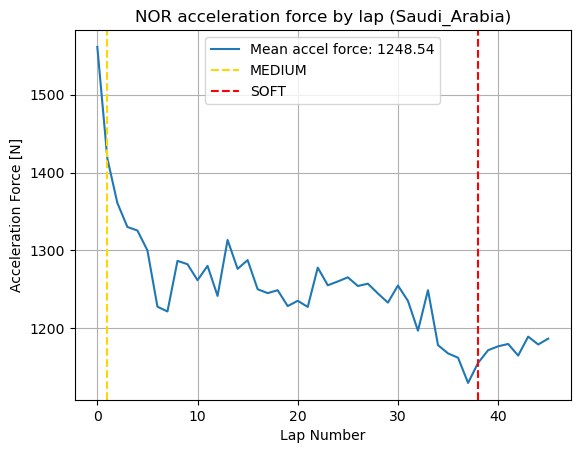

In [144]:
mean_accel_force_by_lap = resampled_accel_lap_data[["LapNumber", "AccelForce"]].groupby("LapNumber").mean()
race_accel_force = np.mean(mean_accel_force_by_lap["AccelForce"].values)
plt.plot(np.arange(len(mean_accel_force_by_lap)), mean_accel_force_by_lap["AccelForce"].values, label=f"Mean accel force: {race_accel_force:.2f}")

compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'gold',
    'HARD': 'gray',
    'INTERMEDIATE': 'green',
    'WET': 'blue'
}

lap_compounds = select_lap_data["Compound"].values
laps_tyre_life = select_lap_data["TyreLife"].values
track_statuses = select_lap_data["TrackStatus"].values
current_compound = lap_compounds[0]

plt.axvline(x=select_lap_data["LapNumber"].values[0], color=compound_colors[current_compound], linestyle='--', label=f"{current_compound}")
for i in range(len(lap_compounds)):
    if i < len(lap_compounds) - 1 and laps_tyre_life[i] >= laps_tyre_life[i + 1]:
        current_compound = lap_compounds[i + 1]
        plt.axvline(x=select_lap_data["LapNumber"].values[i+1], color=compound_colors[current_compound], linestyle='--', label=f"{current_compound}")

plt.xlabel("Lap Number")
plt.ylabel("Acceleration Force [N]")
plt.title(f"{driver_id} acceleration force by lap ({circuit_name})")
plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

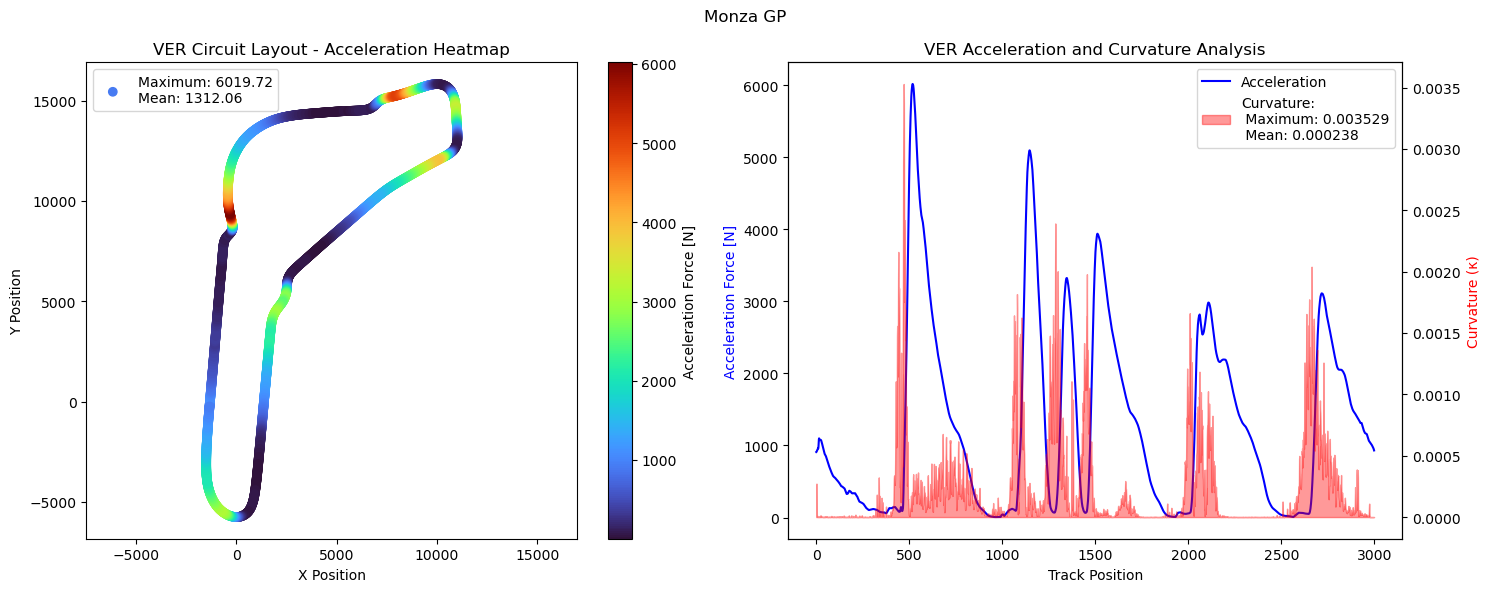

In [138]:
max_accel_force = max(result_stats["AccelForceMean"].values)
race_mean_accel_force = np.mean(result_stats["AccelForceMean"].values)

max_curvature = max(result_stats["Curvature"].values)
mean_curvature = np.mean(result_stats["Curvature"].values)

points = len(result_stats)
# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


# Circuit plot with acceleration heatmap
scatter = ax1.scatter(x_smooth, y_smooth, c=result_stats["AccelForceMean"].values, cmap='turbo', label=f"Maximum: {max_accel_force:.2f}\nMean: {race_mean_accel_force:.2f}")
ax1.set_title(f'{driver_id} Circuit Layout - Acceleration Heatmap')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.legend()
plt.colorbar(scatter, ax=ax1, label='Acceleration Force [N]')
ax1.axis('equal')

# Acceleration and curvature vs track position
ax2.plot(range(points), result_stats["AccelForceMean"].values, label='Acceleration', color='blue')
ax2_twin = ax2.twinx()
ax2_twin.fill_between(range(points), result_stats["Curvature"].values, color='red', alpha=0.4, 
              label=f"Curvature:\n Maximum: {max_curvature:.6f}\n Mean: {mean_curvature:.6f}")

ax2.set_xlabel('Track Position')
ax2.set_ylabel('Acceleration Force [N]', color='blue')
ax2_twin.set_ylabel('Curvature (κ)', color='red')
ax2.set_title(f'{driver_id} Acceleration and Curvature Analysis')

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
fig.suptitle(f"{track_name} GP")
plt.tight_layout()
plt.show()